In [1]:
from PIL import Image
import numpy as np
import torch

from upsample_anything import UPA, dinov2_infer
from utils import visualize_pca_one, visualize_all

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:54: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


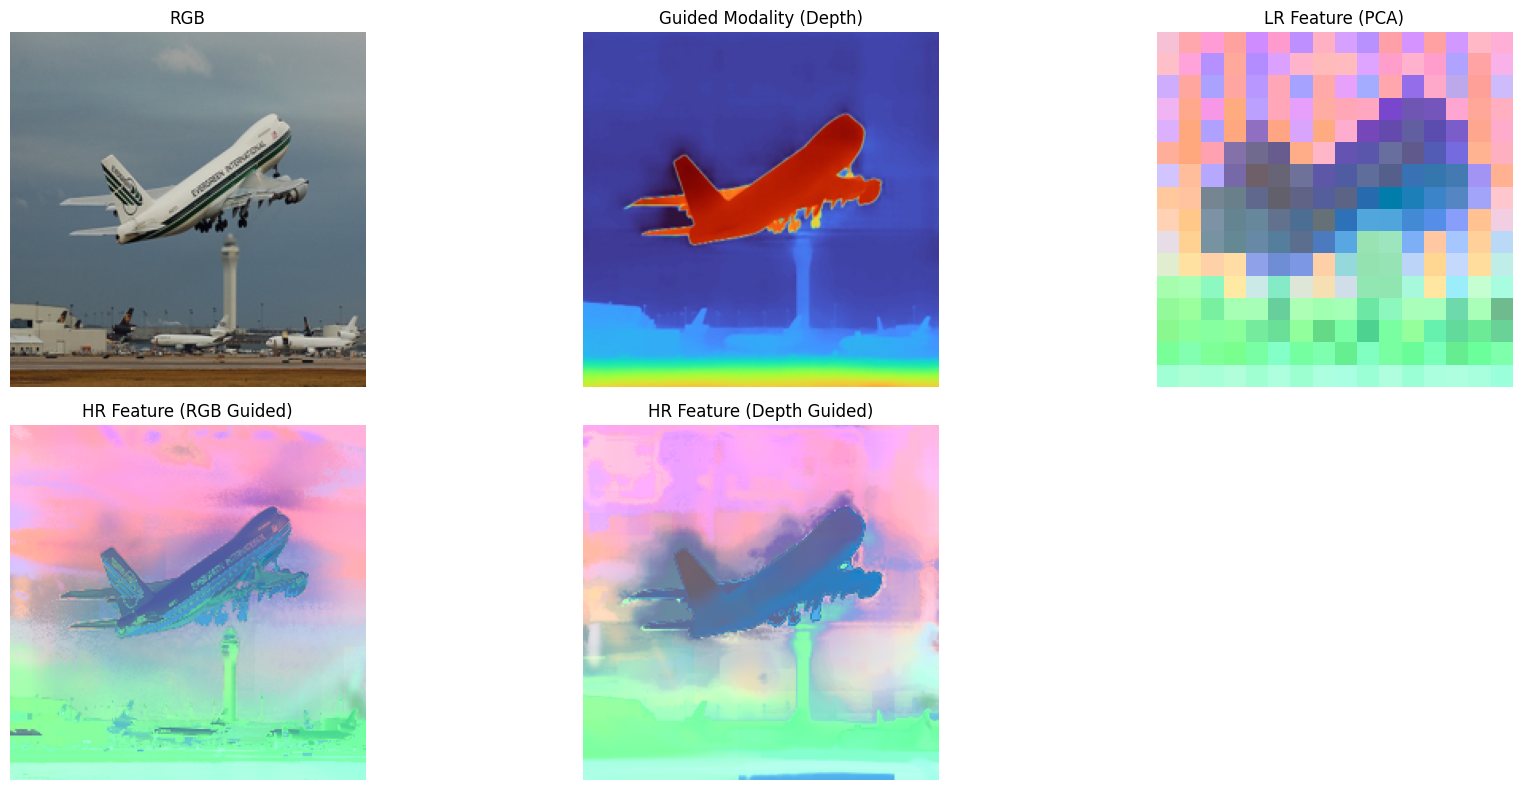

(array([[[0.9667634 , 0.76010287, 0.83761054],
         [1.        , 0.6563074 , 0.68219745],
         [1.        , 0.6082097 , 0.8354782 ],
         [1.        , 0.63773763, 0.6250912 ],
         [0.81287736, 0.55034006, 1.        ],
         [1.        , 0.60461307, 0.81256217],
         [0.74739873, 0.56646013, 1.        ],
         [1.        , 0.69574356, 0.76858026],
         [0.8401718 , 0.6290433 , 1.        ],
         [0.7218481 , 0.5721236 , 1.        ],
         [1.        , 0.6276889 , 0.6663215 ],
         [0.83504725, 0.57650304, 1.        ],
         [1.        , 0.62814385, 0.6403043 ],
         [0.8227024 , 0.5993644 , 1.        ],
         [1.        , 0.72307503, 0.7791655 ],
         [1.        , 0.6828703 , 0.84134775]],
 
        [[1.        , 0.7512933 , 0.7891011 ],
         [1.        , 0.6430126 , 0.8550247 ],
         [0.7073698 , 0.5720488 , 1.        ],
         [1.        , 0.663955  , 0.6134602 ],
         [0.70583904, 0.5546323 , 1.        ],
         [

In [2]:
img_path = "../img/airplane2.jpg"
img = Image.open(img_path).convert("RGB").resize((224, 224))

depth_path = "../img/airplane2_depth.jpg"
guided_modality = Image.open(depth_path).convert("RGB").resize((224, 224))

# Extract LR feature
lr_feature = dinov2_infer(img)

# Upsample
hr_rgb   = UPA(img, lr_feature)
hr_depth = UPA(guided_modality, lr_feature)

# ===>>> Jupyter Visualization <<<===
visualize_all(img, guided_modality, lr_feature, hr_rgb, hr_depth)